# Formating the DME Dataset correctly

1. download dataset from (https://www.kaggle.com/datasets/paultimothymooney/chiu-2015/data)


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio

In [20]:
class DMEDataProcessor:

    def __init__(self,
                DME_dataset_path = "/data/david/DME",
                dataset_path = "2015_BOE_Chiu",
                train_img_path = "images/training",
                train_ann_path = "annotations/training",
                train_subjects = list(range(9)),
                val_img_path = "images/validation",
                val_ann_path = "annotations/validation",
                val_subjects = [9],
                img_suffix = ".png",
                ann_suffix = "_manual1.png",
                clear_contents = True
                ):
        
        #path to the DME dataset and the specific folder
        #with the data to be used to generate the dataset
        self.DME_dataset_path = os.path.join(DME_dataset_path,dataset_path)

        #the paths to save the 
        # generated training and validation datasets
        self.train_img_path = os.path.join(DME_dataset_path,train_img_path)
        self.train_ann_path = os.path.join(DME_dataset_path,train_ann_path)
        self.val_img_path = os.path.join(DME_dataset_path,val_img_path)
        self.val_ann_path = os.path.join(DME_dataset_path,val_ann_path)

        #which subjects to use for training/validation
        self.train_subjects = train_subjects
        self.val_subjects = val_subjects

        #known indicies at where there is data stored
        self.subject_paths = [os.path.join(self.DME_dataset_path,"Subject_{:02d}.mat".format(i+1)) for i in range(10)]

        #suffixes for the generated dataset
        self.img_suffix = img_suffix
        self.ann_suffix = ann_suffix
        
        #initialize the directories
        self._init_directories(clear_contents)
    
    def _check_save_directory(self,path,clear_contents=True):
        """Check a given directory which will be used to save the generated datset files

        Args:
            path (str): absolute path to the directory which is to be checked
            clear_contents (bool, optional): On True, clears existing data from the directory if it already exists. Defaults to True.
        """

        if os.path.isdir(path):
            print("DMEDataProcessor._check_save_directory: found directory {}".format(path))

            #if clear contents is true, wipe out the existing dataset
            if clear_contents:
                print("DMEDataProcessor._check_save_directory: clearing contents of {}".format(path))

                #clear the contents
                for file in os.listdir(path):
                    file_path = os.path.join(path,file)

                    try:
                        if os.path.isfile(file_path):
                            os.remove(file_path)
                    except Exception as e:
                        print("Failed to delete {}".format(path))
        
        else:
            print("DMEDataProcessor._check_save_directory: creating directory {}".format(path))
            os.makedirs(path)
    
    def _init_directories(self, clear_contents=True):
        """Initialize the training and validation directories and their corresponding subdirectories

        Args:
            clear_contents (bool, optional): On True, clears any files that previously existed in the directories. Defaults to True.
        """
        #initiallize training directories
        self._check_save_directory(self.train_img_path,clear_contents)
        self._check_save_directory(self.train_ann_path,clear_contents)

        #initialize validation directories
        self._check_save_directory(self.val_img_path,clear_contents)
        self._check_save_directory(self.val_ann_path,clear_contents)
    
    
    def generate_train_val_datasets(self):

        #generate the training dataset
        print("DMEDataProcessor.generate_train_val_datasets: generating training dataset")
        self._generate_dataset(self.train_subjects,self.train_img_path,self.train_ann_path)
        print("DMEDataProcessor.generate_train_val_datasets: generating validation dataset")
        self._generate_dataset(self.val_subjects,self.val_img_path,self.val_ann_path)

    
    def _generate_dataset(self, subjects, img_path,ann_path):

        #define a common sample idx so that samples
        #  can be generated from multiple subjects
        next_sample_idx = 0

        for subject_idx in tqdm(range(len(subjects))):
            
            next_sample_idx = self._save_subject_samples(subject_idx,next_sample_idx,img_path,ann_path)

    def _save_subject_samples(self,subject_idx,next_sample_idx,img_path,ann_path):

        #save the next_sample_idx
        next_sample_idx = next_sample_idx

        #load the subject's .mat file
        mat = scipy.io.loadmat(self.subject_paths[subject_idx])

        #load the image and annotation tensors
        img_array = np.transpose(mat['images'], (2,0,1)).astype(np.uint8)
        # fluid_tensor = mat['automaticFluidDME']
        # fluid_tensor = mat['manualFluid2']
        fluid_array = np.transpose(mat['manualFluid1'], (2,0,1))
        fluid_array = np.nan_to_num(fluid_array).astype(np.uint8)

        for data_idx in range(fluid_array.shape[0]):
            
            next_sample_idx = self._save_img_ann(data_idx,img_array,fluid_array,img_path,ann_path, next_sample_idx)
        
        return next_sample_idx

    def _save_img_ann(self,data_idx, img_array, fluid_array, img_path,ann_path, next_sample_idx):

        #get the image
        img = img_array[data_idx]

        #get the annotation
        ann = fluid_array[data_idx]
        ann[ann != 0] = 1

        
        if np.count_nonzero(ann) != 0: #save the image and increment the next sample index
            
            #save the data
            save_img_path = os.path.join(img_path,"{:04d}{}".format(next_sample_idx,self.img_suffix))
            save_ann_path = os.path.join(ann_path,"{:04d}{}".format(next_sample_idx,self.ann_suffix))

            #save the image
            imageio.imwrite(save_img_path,img)
            #save the annotation
            imageio.imwrite(save_ann_path,ann)
        
            return next_sample_idx + 1

        else: #don't increment the next sample index

            return next_sample_idx
    
    
    def _load_img_ann_from_file(self,sample_idx, img_path,ann_path):

        #save the data
        save_img_path = os.path.join(img_path,"{:04d}{}".format(sample_idx,self.img_suffix))
        save_ann_path = os.path.join(ann_path,"{:04d}{}".format(sample_idx,self.ann_suffix))

        img = imageio.imread(save_img_path)
        ann = imageio.imread(save_ann_path)

        return img, ann
    
    def _plot_img_ann_from_file(self, sample_idx, img_path, ann_path):

        #load the data
        img, ann = self._load_img_ann_from_file(sample_idx, img_path, ann_path)

        fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
        fig.subplots_adjust(wspace=0.2)

        #plot the image
        axs[0].imshow(img,cmap="gray")
        axs[0].set_title("Input Image")
        axs[0].axis("off")
        axs[1].imshow(ann*255,cmap="gray")
        axs[1].set_title("Annotation")
        axs[1].axis("off")

    def plot_train_img_ann(self,sample_idx):

        self._plot_img_ann_from_file(sample_idx,self.train_img_path, self.train_ann_path)
    
    def plot_val_img_ann(self,sample_idx):

        self._plot_img_ann_from_file(sample_idx,self.val_img_path, self.val_ann_path)

In [21]:
# subject_path = [os.path.join(dataset_path,"Subject_{:02d}.mat".format(i+1)) for i in range(10)]

generator = DMEDataProcessor(
    DME_dataset_path="/data/david/DME",
    img_suffix = ".png",
    ann_suffix = "_manual1.png",
)

generator.generate_train_val_datasets()

DMEDataProcessor._check_save_directory: found directory /data/david/DME/images/training
DMEDataProcessor._check_save_directory: clearing contents of /data/david/DME/images/training
DMEDataProcessor._check_save_directory: found directory /data/david/DME/annotations/training
DMEDataProcessor._check_save_directory: clearing contents of /data/david/DME/annotations/training
DMEDataProcessor._check_save_directory: found directory /data/david/DME/images/validation
DMEDataProcessor._check_save_directory: clearing contents of /data/david/DME/images/validation
DMEDataProcessor._check_save_directory: found directory /data/david/DME/annotations/validation
DMEDataProcessor._check_save_directory: clearing contents of /data/david/DME/annotations/validation
DMEDataProcessor.generate_train_val_datasets: generating training dataset


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


DMEDataProcessor.generate_train_val_datasets: generating validation dataset


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


/tmp/ipykernel_512485/1786561387.py:161: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(save_img_path)
/tmp/ipykernel_512485/1786561387.py:162: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ann = imageio.imread(save_ann_path)


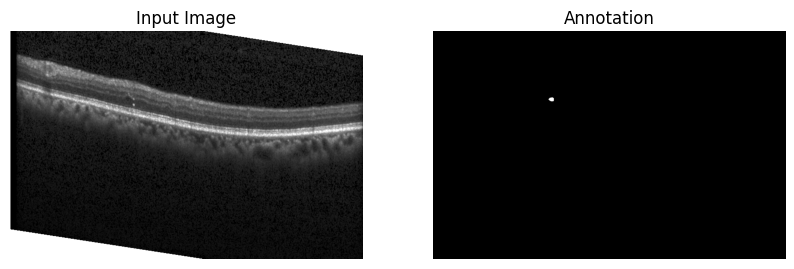

In [11]:
generator.plot_train_img_ann(sample_idx=68)

/tmp/ipykernel_512485/1786561387.py:161: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(save_img_path)
/tmp/ipykernel_512485/1786561387.py:162: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ann = imageio.imread(save_ann_path)


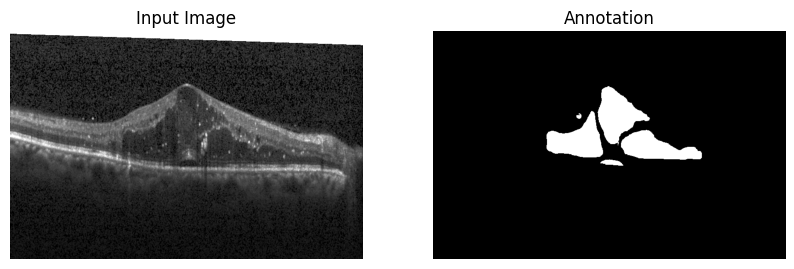

In [12]:
generator.plot_val_img_ann(sample_idx=5)